results are wrong

placing of random seed is crucial 

In [65]:
import numpy as np
import matplotlib.pyplot as plt

In [66]:
def source1(no_of_users)->np.ndarray:
    return np.random.uniform(-1, 1, (no_of_users))
    # return np.array([0.1, 0.1, 0.1, 0.1, 0.1])

Changed bi

In [67]:
plotting=0
comments=1

no_of_sources=7
no_of_slots=4
threshold_prob=0.9999
threshold_prob_range= np.linspace(0.1, 0.99,100)
snr=15
snr_range=np.arange(0,snr+1)
available_power=0.4
slots_range=np.arange(1,no_of_slots+1)

iterations=1

In [68]:
def pre_process1(msg: np.ndarray, cha_coeff: np.ndarray,alpha:float,power:float) -> np.ndarray:   
    # comments=1
    b = alpha/ cha_coeff # Standard preprocessing
    if(comments):
        # print("\t\tb=",b)
        # print("\t\th=",cha_coeff)
        print("\t\tbh=",b*cha_coeff)
        pass 
    return msg * b

def pre_process2(msg: np.ndarray, cha_coeff: np.ndarray,alpha:float,power:float) -> np.ndarray:
    # comments=1
    b = alpha *(cha_coeff/(np.abs(cha_coeff)) ) *np.minimum(1/ (np.abs(cha_coeff)),np.sqrt(power)/alpha) # Standard preprocessing
    if(comments):
        # print("\t\tb=",b)
        # print("\t\th=",cha_coeff)
        print("\t\tbh=",b*cha_coeff)
        pass 
    return msg * b


instead of ∑x_i b_i h_i + n  changed to  ∑x_i b_i h_i + n_i

In [69]:
def awgn_mac_with_channel_coeff(symbols, snr_db,channel_coeff)->np.ndarray:
    
    faded_symbols=symbols*channel_coeff# This corresponds to y = x_i * h_i
    
    if(comments):
        print("\t\txb=",symbols)
        print("\t\th=",channel_coeff)
        print("\t\txbh=",faded_symbols,np.sum(faded_symbols))
        pass
    
    signal_power = np.mean(np.abs(symbols) ** 2)   # Signal power calculation
    snr_linear = 10**(snr_db / 10.0)
    noise_variance = signal_power / (snr_linear)
    noise =np.sqrt(noise_variance) * np.random.randn(*faded_symbols.shape)# Noise generation
    
    combined_faded_symbols =np.sum(faded_symbols) + np.sum(noise)
    # noise=0
    
    if(comments):
        print("\t\t∑xbh=",combined_faded_symbols)
        print("\t\tn=",noise)
        pass
    return combined_faded_symbols,noise_variance

changed bi

In [70]:
def demod1(received_signal,cha_coeff,power:float,alpha:float,noise_variance:float)->np.ndarray:
    if(comments):
        print("\t\tr'=",received_signal)
        pass
    b=alpha / cha_coeff
    a_opt=( np.sum(b*cha_coeff) )   /  ( (np.sum((b*cha_coeff)**2)) + (noise_variance) )
    # a_opt=1
    return received_signal*a_opt

def demod2(received_signal,cha_coeff,power:float,alpha:float,noise_variance:float)->np.ndarray:
    if(comments):
        print("\t\tr'=",received_signal)
        pass
    b=alpha*(cha_coeff/(np.abs(cha_coeff)) ) *np.minimum(1/ (np.abs(cha_coeff)),np.sqrt(power)/alpha) # Standard preprocessing
    a_opt=( np.sum(b*cha_coeff) )   /  ( (np.sum((b*cha_coeff)**2)) + (noise_variance) )
    # a_opt=1
    return received_signal*a_opt

input parmaeters

In [71]:
mse = []
for snr in snr_range: 
    rnd_seed=20
    np.random.seed(rnd_seed)
    alpha=np.sqrt( 2* np.log(  (1/ (1-(1-threshold_prob )**(1/no_of_slots))  )  ) )
    channel_threshold=alpha/ np.sqrt(available_power) 
    if(comments):   
        print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
        print("parameter::",snr,"power",available_power,"channel threshold",channel_threshold)
        pass
    
    error=[]
    for j in range(iterations):
        
        # np.random.seed(np.random.randint(0,100000)) 
               
        source_main=source1(no_of_sources)
        if(comments):
            print(" iter ",j+1,100*"*")
            print("source:",source_main,source_main.sum())
            
        source=source_main.copy()
        recovered_appending=np.array([])
        for i in slots_range:
        #upto N-1 slots
            if(i<no_of_slots):
                channel_coeff=np.random.randn(len(source))
                if(comments):
                    print(f"\tslot {i}")
                    print(f"\t\th'={np.abs(channel_coeff)}")
                    pass
                eligible_msgs=source[np.abs(channel_coeff)>channel_threshold] 
                # if there are msgs to send
                if len(eligible_msgs) == 0:
                    continue
                
                if(plotting):
                    # Plot the main messages with labels
                    plt.figure(figsize=(4,3))
                    plt.plot(np.arange(len(eligible_msgs)), eligible_msgs, "o", markersize=14, label="Main Messages", color="blue")
                    plt.title(f"messges for everys slot (Iteration {j+1}, SNR={snr} ,slot={i})")
                    plt.xlabel("Message Index")
                    plt.ylabel("Message Value")
                    plt.ylim(-1,1)
                    plt.grid(True)
                    pass

                non_transmitted=source[np.abs(channel_coeff)<=channel_threshold]  
                
                channel_gains=channel_coeff[np.abs(channel_coeff)>channel_threshold]  
                
                if(comments):
                    print(f"\t\tx={eligible_msgs}")
                    pass              

                transmitted=pre_process1(eligible_msgs,channel_gains,alpha,available_power)

                if(plotting):
                    # Plot pre-processed messages from the current slot on the combined plot
                    # Adjust the x-index to match the length of the transmitted vector
                    x_axis = np.arange(len(transmitted))
                    plt.plot(x_axis, transmitted, "o", markersize=12)
                    plt.ylim(-1,1)
                    # plt.legend()
                    pass

                received,noise_var= awgn_mac_with_channel_coeff(transmitted, snr,channel_gains)
                if(plotting):
                    plt.plot( received, "h", markersize=10)
                    plt.ylim(-1,1)
                    pass   
                
                recovered_signal=demod1(received,channel_gains,available_power,alpha,noise_var)

                recovered_appending=np.append(recovered_appending,recovered_signal)
                
                if(comments):
                    print("\t\tr=",recovered_signal)
                    # print("\t\t---------------------------------------------")
                    pass
                source=non_transmitted



          
                #if some node haven't sent in prevous slots
            if i==no_of_slots:
                if len(source) == 0:
                    continue                
                if(comments):
                    print(f"\tslot {i}")
                    print(f"\t\tx={non_transmitted}")
                    pass
                
                channel_gains=np.random.randn(len(non_transmitted))

                if(plotting):
                    plt.figure(figsize=(4,3))
                    plt.plot(np.arange(len(non_transmitted)), non_transmitted, "o", markersize=14, label="Main Messages", color="blue")
                    plt.title(f"messges for everys slot (Iteration {j+1}, SNR={snr},slot={i})")
                    plt.xlabel("Message Index")
                    plt.ylabel("Message Value")
                    plt.ylim(-1,1)
                    # plt.legend()
                    plt.grid(True)
                    pass
                                
                transmitted=pre_process2(non_transmitted,channel_gains,alpha,available_power)
                if(plotting):
                    # Plot pre-processed messages from the current slot on the combined plot
                    # Adjust the x-index to match the length of the transmitted vector
                    x_axis = np.arange(len(transmitted))
                    plt.plot(x_axis, transmitted, "o", markersize=12)
                    plt.ylim(-1,1)
                    # plt.legend()
                    pass
                
                received,noise_var= awgn_mac_with_channel_coeff(transmitted, snr,channel_gains)
                
                if(plotting):
                    # Plot pre-processed messages from the current slot on the combined plot
                    # Adjust the x-index to match the length of the transmitted vector
                    x_axis = np.arange(len(transmitted))
                    plt.plot(x_axis, received, "h", markersize=10)
                    plt.ylim(-1,1)
                    # plt.legend()
                    pass
                
                recovered_signal=demod2(received,channel_gains,available_power,alpha,noise_var)
                recovered_appending=np.append(recovered_appending,recovered_signal)

                if(comments):
                    print("\t\tr=",recovered_signal)
                    print("\t\t---------------------------------------------")
                    pass
                
        # print("\t\t______________________________________________________________________")
        error.append(np.mean((source_main.sum() - recovered_appending.sum()) ** 2))
        if(comments):
            print("\t\t\tsource sum",source_main.sum())
            print("\t\t\trecovered",recovered_appending.sum())
            print("\t\t\terror",error)
            pass
    mse.append(np.mean(error))
    # print("mse",mse)

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
parameter:: 0 power 0.4 channel threshold 0.7258116686090929
 iter  1 ****************************************************************************************************
source: [ 0.1762616   0.79542746  0.78306146  0.63167495 -0.92822083  0.38351516
 -0.24263812] 1.5990816903004592
	slot 1
		h'=[2.12601055 0.24915543 0.62064216 0.83453294 0.91635593 0.70783847
 0.41967613]
		x=[ 0.1762616   0.63167495 -0.92822083]
		bh= [0.45904361 0.45904361 0.45904361]
		xb= [ 0.03805802 -0.34745944 -0.46498726]
		h= [ 2.12601055 -0.83453294  0.91635593]
		xbh= [ 0.08091176  0.28996635 -0.42609384] -0.05521572584519463
		∑xbh= 0.11417349967500637
		n= [ 0.17939788 -0.27471329  0.26470464]
		r'= 0.11417349967500637
		r= 0.21106089047835505
	slot 2
		h'=[0.6226121  0.42687316 0.08443397 0.61563566]
	slot 3
		h'=[0.53843148 0.63997574 2.30765072 0.1339542 ]
		x=[0.38351516]
		bh= [0.45904361]
		xb= [0.07628979

bh>0 always

In [72]:
print("\nSNR:",snr_range)
print("MSE:",mse)


SNR: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
MSE: [0.48163427994315905, 0.3476610900413632, 0.24538316988458286, 0.16870855659972894, 0.11231167868166576, 0.07171413943764761, 0.04325465137033393, 0.024002373127429897, 0.011648789770827195, 0.004398606746071732, 0.0008701461017222036, 9.541969660836331e-06, 0.0010195161041366178, 0.003301722534731969, 0.0064108908364468534, 0.010018811590555851]


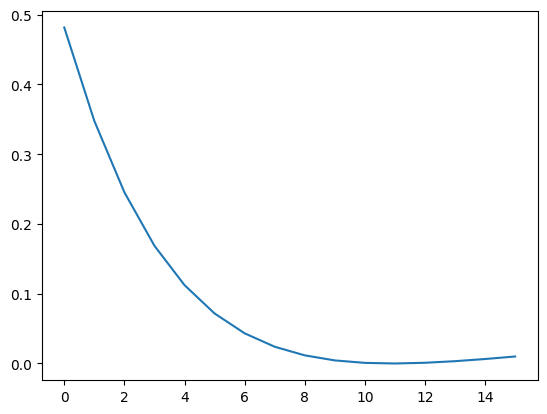

In [73]:
plt.plot(snr_range,mse)
plt.show()